#  Loading Data

In [3]:
#pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [149]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import glob
import cv2
import random

import tensorflow as tf

In [150]:
train_dir = '../Downloads/chest_xray/train'
val_dir = '../Downloads/chest_xray/val'
test_dir = '../Downloads/chest_xray/test'

In [151]:
first_train_files = glob.glob(train_dir +'/*/*')
first_val_files_original = glob.glob(val_dir +'/*/*')
test_files = glob.glob(test_dir +'/*/*')

In [152]:
#Since we have a big difference between number of test and validation images I appended them and splitted with 80:20 proportion
train_val = np.unique(first_train_files + first_val_files_original)
train_files, val_files = train_test_split(train_val, test_size = 0.2)
print('train samples:', len(train_files))
print('val samples:', len(val_files))

train samples: 4185
val samples: 1047


In [153]:
NORMAL_NUM = len([i for i in train_files if "NORMAL" in i])
print("Normal images count in training set: " + str(NORMAL_NUM))

PNEUMONIA_NUM = len([i for i in train_files if "PNEUMONIA" in i])
print("Pneumonia images count in training set: " + str(PNEUMONIA_NUM))

Normal images count in training set: 1076
Pneumonia images count in training set: 3109


# Data pre-processing

In [154]:
IMAGE_SIZE = 180
BATCH_SIZE = 32

In [155]:
def processing(files):
    data = []
    for i in files:
        sections = tf.strings.split(i, os.path.sep)
        assert  sections[-2] in ['NORMAL', 'PNEUMONIA']
        label = 1 if sections[-2] == "PNEUMONIA" else 0     
        img_arr = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (IMAGE_SIZE, IMAGE_SIZE))
        data.append([resized_arr, label])
    return np.array(data)
        
    

In [156]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

train = processing(train_files)
val =   processing(val_files)
test =  processing(test_files)

In [157]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:   
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [158]:
x_train[0]

array([[ 75, 106,  33, ...,  40,  43,  50],
       [180, 168, 162, ...,  39,  43,  49],
       [184, 168, 148, ...,  38,  41,  43],
       ...,
       [ 28,  27,  29, ...,  56,  55,  59],
       [ 28,  27,  29, ...,  56,  55,  77],
       [ 28,  28,  28, ...,  54,  64,  40]], dtype=uint8)

In [159]:
#Scaling
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [160]:
x_train = x_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
y_test = np.array(y_test)

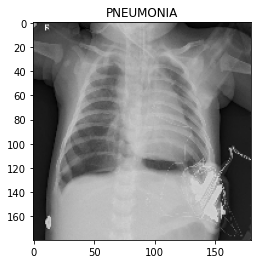

In [161]:
plt.imshow(x_train[0].reshape(180,180), cmap='gray')
if y_train[0] == 0 :
    plt.title("NORMAL")
else: plt.title("PNEUMONIA")

# Model Building

In [162]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(180, 180)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [ ]:
#First we need to flattern our matrix in form of list(array) in order to be able to take it as an input(each node holds value 
#between 0 to 1 depending on pixel density) and each of them made connections with  neurons of hidden layer. 
#Last layer with two neurons  is our final output 1 or 0 pneumania or normal 
#The didgits that they hold, represents how mutch system thinks that a given image correspond to
# the given categories. In the hidden layer when we train our data we notice that normal images correspond to certain patterns in
# the hiddem layer as well as pneumonia images. Going to the last layer from the hidden layer requieres recognition 
#of this patters. To connect input nodes with hidden layer nodes, networks need to have certain parameters. That's why we need
#to to assign weights to each of the connections then we take each input and compute their waighted sum. Becuse output could 
#some big or small value but we need some number between 0 and 1 so that why we put this weighted sum into function that
#squishes the result betwee 1 and 0 range. In this case for this we used activation function 'relu'

In [163]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [164]:
model.fit(x_train, y_train, epochs=10, batch_size= BATCH_SIZE, validation_data=(x_val,y_val))

Epoch 1/10
131/131 [==============================] - 6s 46ms/step - loss: 1.4567 - accuracy: 0.8072 - val_loss: 0.1953 - val_accuracy: 0.9341
Epoch 2/10
131/131 [==============================] - 6s 45ms/step - loss: 0.1720 - accuracy: 0.9357 - val_loss: 0.1380 - val_accuracy: 0.9513
Epoch 3/10
131/131 [==============================] - 7s 51ms/step - loss: 0.1562 - accuracy: 0.9400 - val_loss: 0.1845 - val_accuracy: 0.9198
Epoch 4/10
131/131 [==============================] - 6s 43ms/step - loss: 0.1644 - accuracy: 0.9331 - val_loss: 0.1564 - val_accuracy: 0.9436
Epoch 5/10
131/131 [==============================] - 6s 46ms/step - loss: 0.1461 - accuracy: 0.9419 - val_loss: 0.1639 - val_accuracy: 0.9351
Epoch 6/10
131/131 [==============================] - 7s 51ms/step - loss: 0.1268 - accuracy: 0.9486 - val_loss: 0.1130 - val_accuracy: 0.9522
Epoch 7/10
131/131 [==============================] - 7s 50ms/step - loss: 0.1353 - accuracy: 0.9486 - val_loss: 0.2417 - val_accuracy: 0.9169

In [165]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

20/20 - 0s - loss: 0.9892 - accuracy: 0.7436

Test accuracy: 0.7435897588729858


# Prediction

In [166]:
#so ouputs cold be more understandable
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [241]:
predictions = probability_model.predict(x_test)


In [279]:
np.argmax(predictions[0])

1

In [276]:
#Actual value
y_test[0]

0

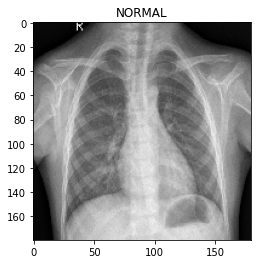

In [251]:
plt.imshow(x_test[6].reshape(180,180), cmap='gray')
if y_test[6] == 0 :
    plt.title("NORMAL")
else: plt.title("PNEUMONIA")

In [255]:
class_names= ['NORMAL', 'PNEUMONIA']
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
                                      true_label = true_label[i]
                                      plt.grid(False)
                                      plt.xticks(range(2))
                                      plt.yticks([])
                                      thisplot = plt.bar(range(2), predictions_array, color="#777777")
                                      plt.ylim([0, 1])
                                      predicted_label = np.argmax(predictions_array)

                                      thisplot[predicted_label].set_color('red')
                                      thisplot[true_label].set_color('blue')


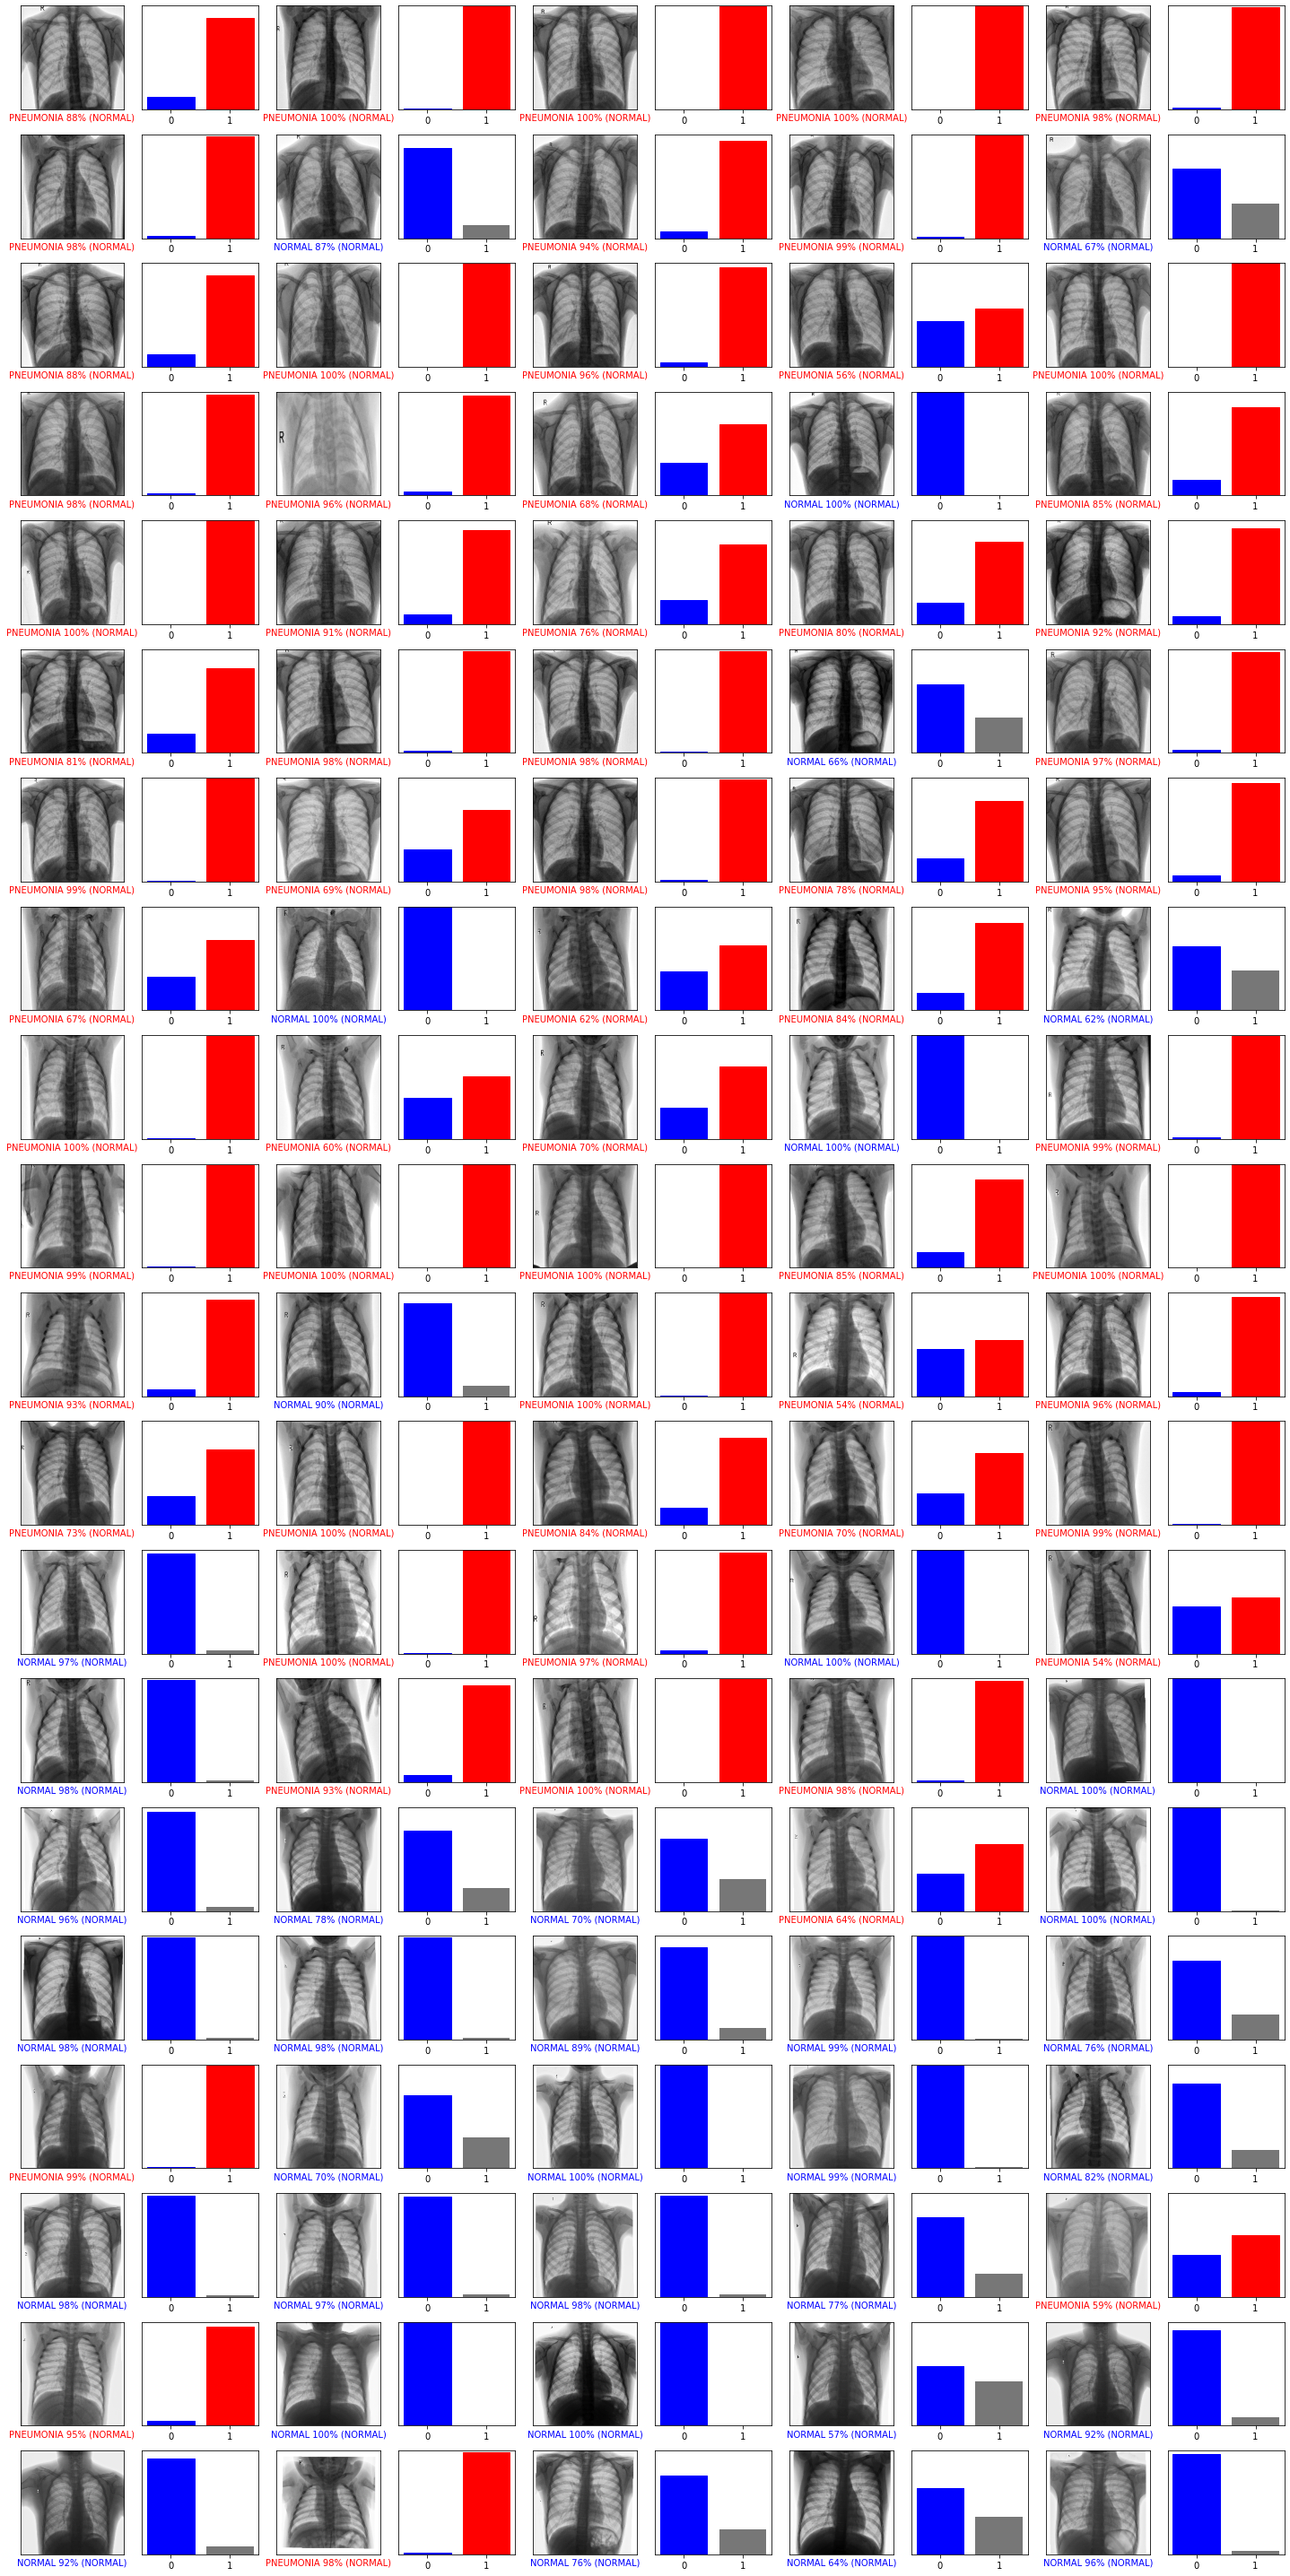

In [263]:
num_rows = 20
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
                  plt.subplot(num_rows, 2*num_cols, 2*i+1)
                  plot_image(i, predictions[i], y_test, x_test)
                  plt.subplot(num_rows, 2*num_cols, 2*i+2)
                  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [ ]:
#At first becase of few elements didn't mutch prediction i started to think hot it gives more that 70% accuracy then I see that 
#most of the correct prediction are after some elements at the top

# Task3

In [280]:
#I find error measures by evaluate() function
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

20/20 - 0s - loss: 0.9892 - accuracy: 0.7436

Test accuracy: 0.7435897588729858


In [281]:
#We can see there is a gap between train and tes data set accurasy 
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)

131/131 - 2s - loss: 0.0960 - accuracy: 0.9627


In [ ]:
#In the begging I merged validation and train data in order to see if there are some overfitting
#by comparing their results and  there were not enouph validation data

#To make my code more accurate I scaled my data with max value of pixel density then used Adam optimizer(optimization algorithm
#that uses/uodates gradient decent and momentum efficintaly) 